In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="code."></form>''')

# Introducción

En presente trabajo se analizaron los resultados productivos de una empresa productora de pollos parrilleros para detectar las variables que impactan sobre los resultados y realizar recomendaciones a partir de ello. En segunda instancia se construyó un modelo de regresión 

## Obtención de base de datos

In [19]:
# Se presentan las librerías utilizadas:
# Importaciones
import numpy as np
import pandas as pd
#import pandas_profiling
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import xlsxwriter
import datetime
import statsmodels.api as sm
import requests
import json
import plotly.express as px
import ydata_profiling
from matplotlib import rcParams
from numpy import mean
from numpy import std

# Para modelaje:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import VotingRegressor
from imblearn import FunctionSampler
from sklearn import metrics
%pip install ipython-autotime
%load_ext autotime
import pickle
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import preprocessing

Note: you may need to restart the kernel to use updated packages.
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5.98 s (started: 2023-06-24 22:19:08 -03:00)


In [20]:
#Ingresos semanales compilado registra resultados finales de la producción en la pestaña BASE. Contiene además datos de genética, nutrición y sanidad.
df = pd.read_excel(r"C:\Users\ebover\OneDrive - FRIGORIFICO DE AVES SOYCHU S.A.I.C.F.I.A\ingresos semanales compilado.xlsx",sheet_name='BASE', skiprows=1 , usecols=range(1,67))

time: 13.2 s (started: 2023-06-24 22:19:27 -03:00)


## Feature extraction preliminar

In [21]:
df.drop(df[(df['A.D.'] >100)].index, inplace=True) #Se eliminan valores erróneos
df.drop(df[(df['Edad'] >70)].index, inplace=True) #Se elimninan edades fuera de estándar
df.drop(df[(df['Destino'] =='EXP')].index, inplace=True) # se eliminan crianzas de pollos enviados a exportación


time: 47 ms (started: 2023-06-24 22:19:43 -03:00)


In [ ]:
columns_names = df.columns.values
columns_names

In [22]:
#subset para modelo
dfm=df[['Días de receso corregido','granja','Cantid. BB','% a 7 Días','% Mortan.','Edad','mes levante','Consumo medio diario (g)','Estación del año','Densidad','Ventilación forzada','Ambiente controlado','localidad','zona climática','zona prod' ]]
dfm.head()

,Días de receso corregido,granja,Cantid. BB,% a 7 Días,% Mortan.,Edad,mes levante,Consumo medio diario (g),Estación del año,Densidad,Ventilación forzada,Ambiente controlado,localidad,zona climática,zona prod
0,14,2544,36000,0.55,2.88,49.0,1,115.963592,verano,12.000000,S,N,San Pedro,Arrecifes,BA
1,12,2558,57500,0.83,5.71,52.9,1,117.081839,verano,10.454545,N,N,Salto,Arrecifes,BA
2,11,2761,39000,0.92,6.45,49.0,1,127.820226,verano,9.470000,N,N,Chivilcoy,25 de mayo,BA
3,9,2524,30000,1.35,5.90,49.0,1,127.343729,verano,10.000000,N,N,San Pedro,Arrecifes,BA
4,10,2741,42000,0.76,7.35,51.0,1,138.304026,verano,10.769231,N,N,Arrecifes,Arrecifes,BA


time: 16 ms (started: 2023-06-24 22:19:52 -03:00)


In [23]:
def df_explore(dfm):
    # Tabla de descripción de las principales características de cada columna de un conjunto de datos
    print( 'Shape: ', df.shape)

    t = PrettyTable(['Variable',
                     'Tipo',
                     'Cant. No Nulos',
                     'Cant. Nulos',
                     '% Nulos',
                     'Valores Únicos',
                     'Ejemplo',
                    ])

    for c in dfm.columns:
        t.add_row([c,                                                                                         # Variable
                   dfm[c].dtype,                                                                               # tipo
                   len(dfm[c])-np.sum(dfm[c].isna().sort_values(ascending=False)),                              # Cant. No Nulos
                   np.sum(dfm[c].isna()),                                                                 # Cant. Nulos
                   np.round(dfm[c].isna().sort_values(ascending=False).sum()/len(df)*100, 2),        # % Nulos
                   np.count_nonzero(dfm[c].unique()),                                                          # Valores Únicos
                   dfm[~dfm[c].isnull()][c].iloc[0],                                                            # Ejemplo
                  ])
    print(t)
    print()
    return

df_explore(dfm)

Shape:  (14629, 66)
+--------------------------+---------+----------------+-------------+---------+----------------+--------------------+
|         Variable         |   Tipo  | Cant. No Nulos | Cant. Nulos | % Nulos | Valores Únicos |      Ejemplo       |
+--------------------------+---------+----------------+-------------+---------+----------------+--------------------+
| Días de receso corregido |  int64  |     14629      |      0      |   0.0   |       28       |         14         |
|          granja          |  int64  |     14629      |      0      |   0.0   |      753       |        2544        |
|        Cantid. BB        |  int64  |     14629      |      0      |   0.0   |      2390      |       36000        |
|        % a 7 Días        | float64 |     14629      |      0      |   0.0   |      620       |        0.55        |
|        % Mortan.         | float64 |     14629      |      0      |   0.0   |      2228      |        2.88        |
|           Edad           | float64

In [24]:
c = dfm.corr(numeric_only=True).abs()
s = c.unstack()
correlacion=pd.DataFrame(s)
correlacion.columns=["Correlacion"]
correlaciones_max=correlacion.query("Correlacion>0.8 & Correlacion!=1")

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(correlaciones_max)

Empty DataFrame
Columns: [Correlacion]
Index: []
time: 16 ms (started: 2023-06-24 22:20:03 -03:00)


In [25]:
c = dfm.corr(numeric_only=True).abs()
s = c.unstack()
correlacion=pd.DataFrame(s)
correlacion.columns=["Correlacion"]
correlacion=correlacion[correlacion.index.isin(['Consumo medio diario (g)'], level=0)]
correlacion.query("Correlacion>0.05 & Correlacion!=1").sort_values(by="Correlacion",ascending=False)

Correlacion
Consumo medio diario (g) mes levante                  0.184582
                         Edad                         0.170924
                         % a 7 Días                   0.100126
                         % Mortan.                    0.084959
                         Días de receso corregido     0.073382

time: 31 ms (started: 2023-06-24 22:20:08 -03:00)


In [ ]:
plot=sns.histplot(x="Consumo medio diario (g)", data=dfm);

In [ ]:
sns.scatterplot(x="mes levante",y="Consumo medio diario (g)", data=dfm);

In [ ]:
sns.boxplot(x="Ventilación forzada",y="Consumo medio diario (g)", data=dfm);

# Encoding

## Transformaciones categóricas

In [26]:
dfn=dfm
dfn.head()

,Días de receso corregido,granja,Cantid. BB,% a 7 Días,% Mortan.,Edad,mes levante,Consumo medio diario (g),Estación del año,Densidad,Ventilación forzada,Ambiente controlado,localidad,zona climática,zona prod
0,14,2544,36000,0.55,2.88,49.0,1,115.963592,verano,12.000000,S,N,San Pedro,Arrecifes,BA
1,12,2558,57500,0.83,5.71,52.9,1,117.081839,verano,10.454545,N,N,Salto,Arrecifes,BA
2,11,2761,39000,0.92,6.45,49.0,1,127.820226,verano,9.470000,N,N,Chivilcoy,25 de mayo,BA
3,9,2524,30000,1.35,5.90,49.0,1,127.343729,verano,10.000000,N,N,San Pedro,Arrecifes,BA
4,10,2741,42000,0.76,7.35,51.0,1,138.304026,verano,10.769231,N,N,Arrecifes,Arrecifes,BA


time: 16 ms (started: 2023-06-24 22:20:19 -03:00)


In [27]:
label_encoder = preprocessing.LabelEncoder()
dfn['Estación del año']= label_encoder.fit_transform(dfn['Estación del año'])
dfn['Estación del año'].unique()


label_encoder = preprocessing.LabelEncoder()
dfn['Ambiente controlado']= label_encoder.fit_transform(dfn['Ambiente controlado'])
dfn['Ambiente controlado'].unique()

label_encoder = preprocessing.LabelEncoder()
dfn['localidad']= label_encoder.fit_transform(dfn['localidad'])
dfn['localidad'].unique()

label_encoder = preprocessing.LabelEncoder()
dfn['zona climática']= label_encoder.fit_transform(dfn['zona climática'])
dfn['zona climática'].unique()

label_encoder = preprocessing.LabelEncoder()
dfn['zona prod']= label_encoder.fit_transform(dfn['zona prod'])
dfm['zona prod'].unique()

label_encoder = preprocessing.LabelEncoder()
dfn['Ventilación forzada']= label_encoder.fit_transform(dfn['Ventilación forzada'])
dfn['Ventilación forzada'].unique()

C:\Users\ebover\AppData\Local\Temp\ipykernel_22500\2655755794.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['Estación del año']= label_encoder.fit_transform(dfn['Estación del año'])
C:\Users\ebover\AppData\Local\Temp\ipykernel_22500\2655755794.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['Ambiente controlado']= label_encoder.fit_transform(dfn['Ambiente controlado'])
C:\Users\ebover\AppData\Local\Temp\ipykernel_22500\2655755794.py:11: SettingWithCopyWarning: 
A value is trying to be set 

array([2, 1, 0])

time: 46 ms (started: 2023-06-24 22:20:22 -03:00)


# Feature selection

## Exploratory Data Analysis


# Entrenamiento modelos machine learning

# Modelos de regresión con base completa

In [28]:
from sklearn.model_selection import train_test_split

X3=dfn.drop('Consumo medio diario (g)', axis=1) 

y3=dfn['Consumo medio diario (g)']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.30, random_state=42)

time: 15 ms (started: 2023-06-24 22:20:31 -03:00)


## Linear regression

In [29]:
from sklearn.linear_model import LinearRegression


time: 0 ns (started: 2023-06-24 22:20:34 -03:00)


In [84]:
model = LinearRegression(fit_intercept=True)
model.fit(X3, y3)
y3_train_pred = model.predict(X3_train)
y3_test_pred = model.predict(X3_test)

lr_test_mse = mean_squared_error(y3_test, y3_test_pred)
lr_train_mse = mean_squared_error(y3_train, y3_train_pred)

lr_test_rmse = np.sqrt(lr_test_mse)
lr_train_rmse = np.sqrt(lr_train_mse)

lr_test_mae = mean_absolute_error(y3_test, y3_test_pred)
lr_train_mae = mean_absolute_error(y3_train, y3_train_pred)

lr_test_r2 = r2_score(y3_test, y3_test_pred)
lr_train_r2 = r2_score(y3_train, y3_train_pred)

time: 31 ms (started: 2023-06-24 23:09:28 -03:00)


In [ ]:
model.coef_

In [ ]:
coeff_df2 = pd.DataFrame(model.coef_, X3.columns, columns=['Coefficient']).reset_index()
coeff_df2

In [ ]:
ax=sns.barplot(data=coeff_df2, x='Coefficient',y='index') 
ax.bar_label(ax.containers[0])
ax.set(xlim=(-100, 40))
ax.set(title='Coeficientes de correlación');

# KNN

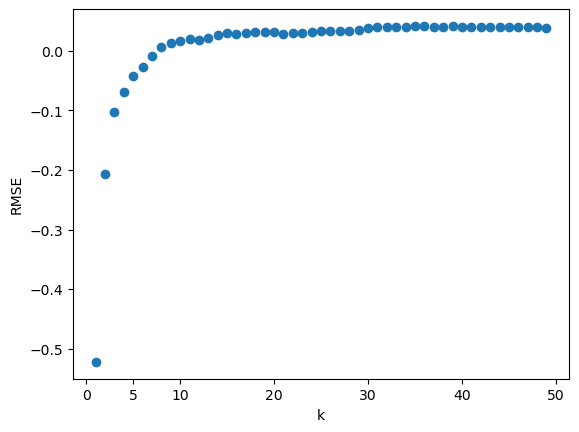

time: 4.17 s (started: 2023-06-24 22:59:36 -03:00)


In [64]:
from sklearn.neighbors import KNeighborsRegressor
k_range = range(1, 50)
scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X3_train, y3_train)
    scores.append(knn.score(X3_test, y3_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('RMSE')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,20,30,40,50]);

In [85]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=10)
model.fit(X3, y3)
y3_train_pred = model.predict(X3_train)
y3_test_pred = model.predict(X3_test)



knr_test_mse = mean_squared_error(y3_test, y3_test_pred)
knr_train_mse = mean_squared_error(y3_train, y3_train_pred)

knr_test_rmse = np.sqrt(knr_test_mse)
knr_train_rmse = np.sqrt(knr_train_mse)

knr_test_mae = mean_absolute_error(y3_test, y3_test_pred)
knr_train_mae = mean_absolute_error(y3_train, y3_train_pred)

knr_test_r2 = r2_score(y3_test, y3_test_pred)
knr_train_r2 = r2_score(y3_train, y3_train_pred)


time: 172 ms (started: 2023-06-24 23:09:34 -03:00)


# Random forest regression

In [86]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X3, y3)
y3_train_pred = model.predict(X3_train)
y3_test_pred = model.predict(X3_test)


rfr_test_mse = mean_squared_error(y3_train, y3_train_pred)
rfr_train_mse = mean_squared_error(y3_test, y3_test_pred)

rfr_test_rmse = np.sqrt(rfr_test_mse)
rfr_train_rmse = np.sqrt(rfr_train_mse)

rfr_test_mae = mean_absolute_error(y3_test, y3_test_pred)
rfr_train_mae = mean_absolute_error(y3_train, y3_train_pred)

rfr_test_r2 = r2_score(y3_test, y3_test_pred)
rfr_train_r2 = r2_score(y3_train, y3_train_pred)

time: 5.39 s (started: 2023-06-24 23:09:38 -03:00)


# Xgboost

In [ ]:
! pip install xgboost

time: 375 ms (started: 2023-06-24 23:09:47 -03:00)


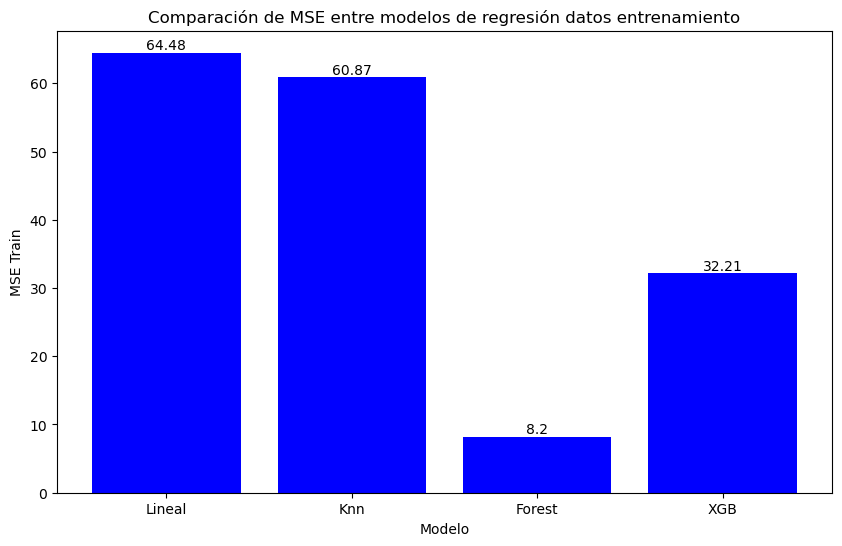

time: 156 ms (started: 2023-06-24 23:09:51 -03:00)


In [88]:
valores = [lr_train_mse, knr_train_mse, rfr_train_mse, xgb_train_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Train')
plt.title('Comparación de MSE entre modelos de regresión datos entrenamiento')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

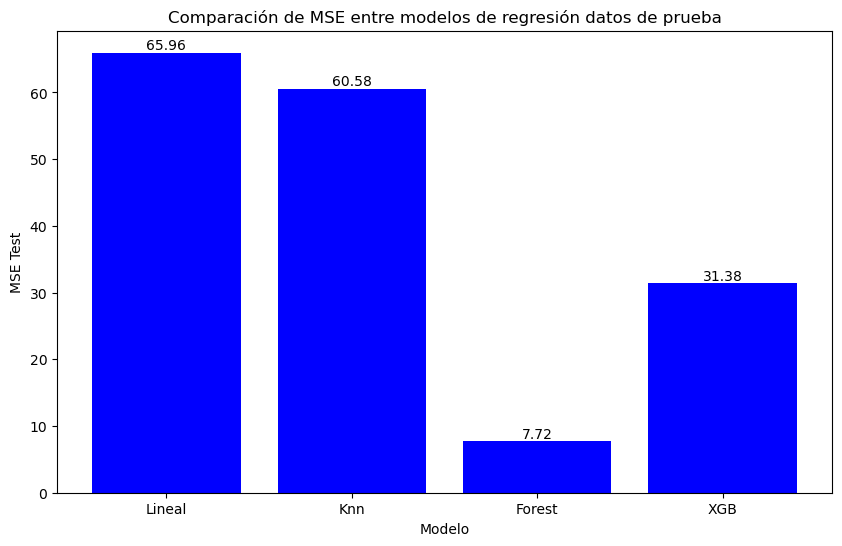

time: 187 ms (started: 2023-06-24 23:09:56 -03:00)


In [89]:
valores = [lr_test_mse, knr_test_mse, rfr_test_mse, xgb_test_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Test')
plt.title('Comparación de MSE entre modelos de regresión datos de prueba')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

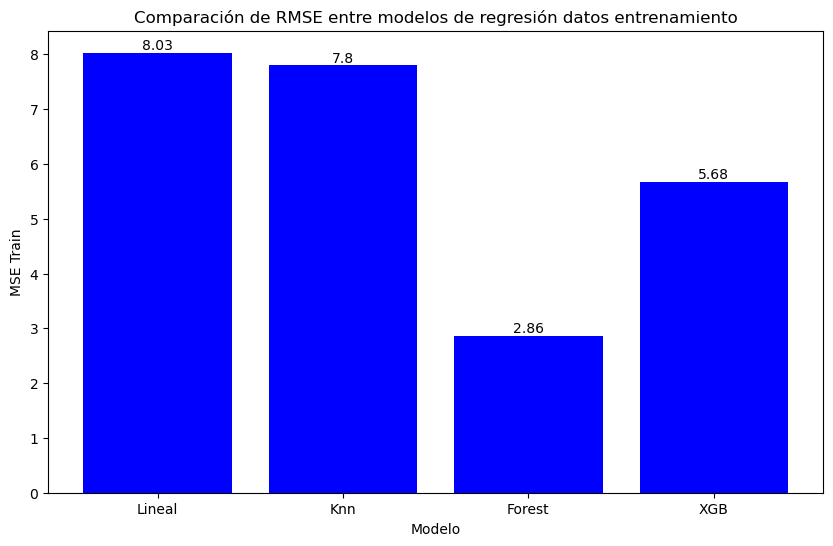

time: 141 ms (started: 2023-06-24 23:10:09 -03:00)


In [90]:
valores = [lr_train_rmse, knr_train_rmse, rfr_train_rmse, xgb_train_rmse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Train')
plt.title('Comparación de RMSE entre modelos de regresión datos entrenamiento')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

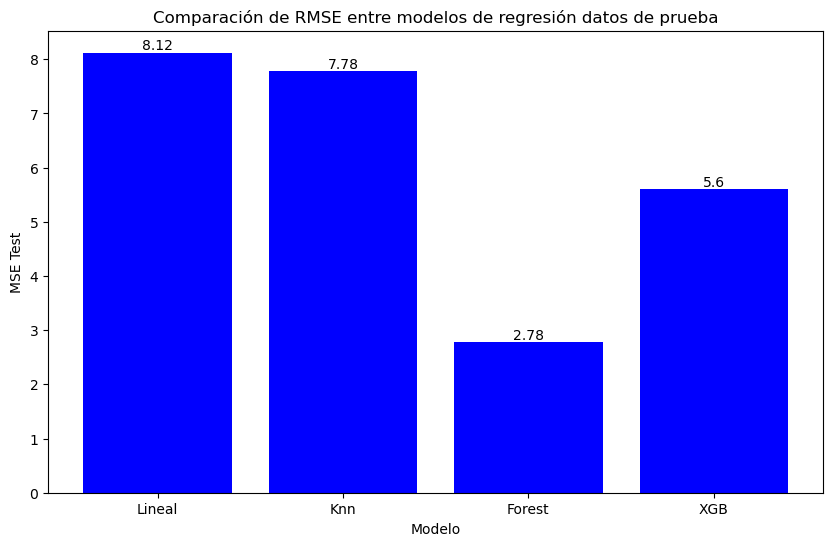

time: 141 ms (started: 2023-06-24 23:11:20 -03:00)


In [91]:
valores = [lr_test_rmse, knr_test_rmse, rfr_test_rmse, xgb_test_rmse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Test')
plt.title('Comparación de RMSE entre modelos de regresión datos de prueba')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

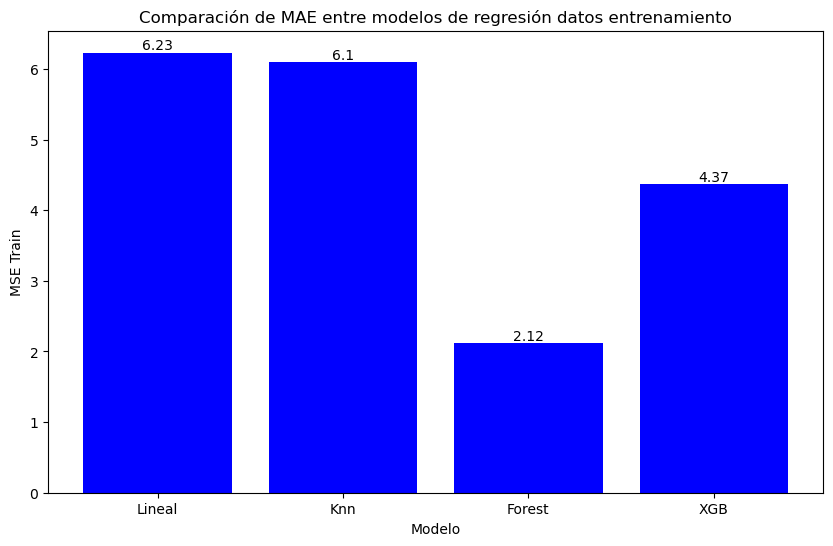

time: 203 ms (started: 2023-06-24 23:11:29 -03:00)


In [92]:
valores = [lr_train_mae, knr_train_mae, rfr_train_mae, xgb_train_mae]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Train')
plt.title('Comparación de MAE entre modelos de regresión datos entrenamiento')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

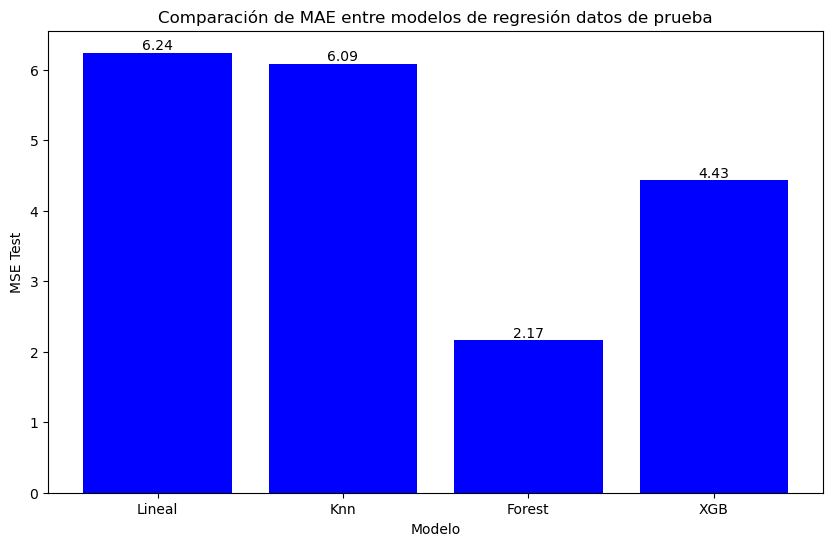

time: 140 ms (started: 2023-06-24 23:11:43 -03:00)


In [93]:
valores = [lr_test_mae, knr_test_mae, rfr_test_mae, xgb_test_mae]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Test')
plt.title('Comparación de MAE entre modelos de regresión datos de prueba')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

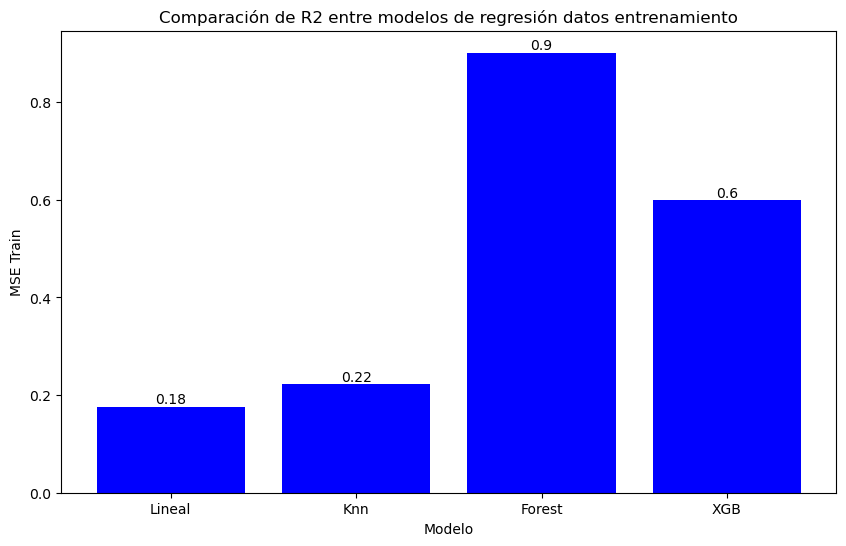

time: 141 ms (started: 2023-06-24 23:11:52 -03:00)


In [94]:
valores = [lr_train_r2, knr_train_r2, rfr_train_r2, xgb_train_r2]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Train')
plt.title('Comparación de R2 entre modelos de regresión datos entrenamiento')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

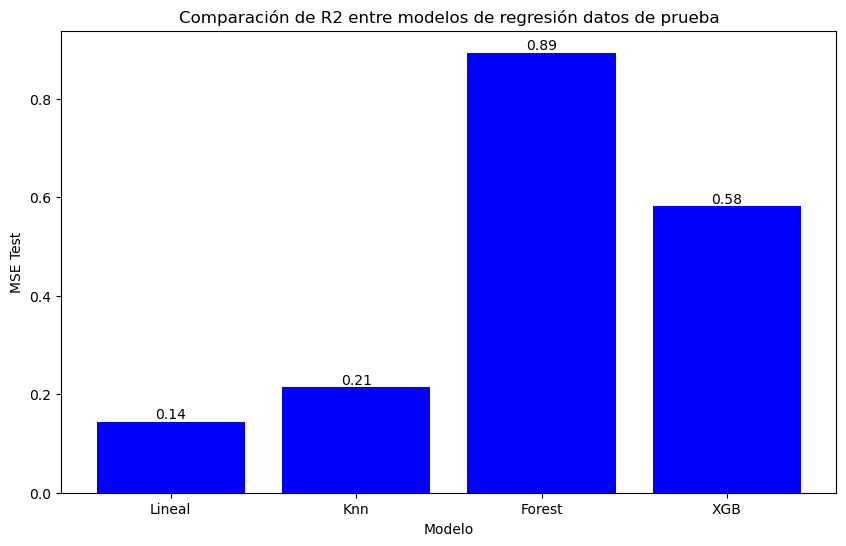

time: 187 ms (started: 2023-06-24 23:12:03 -03:00)


In [95]:
valores = [lr_test_r2, knr_test_r2, rfr_test_r2, xgb_test_r2]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Test')
plt.title('Comparación de R2 entre modelos de regresión datos de prueba')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

Comparando las métricas MSE, RMSE, MAE y R2 de los 4 modelos los mejores valores son para Random Forest en primer lugar y XGB en segundo lugar.

## Validación del modelo

## Stratified-K fold para Random Forest Regressor

In [104]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
# crear el modelo
model = RandomForestRegressor(random_state=42, n_estimators=10,max_depth=4)
scores = cross_val_score(model, X3_train, y3_train, cv=7, verbose=1,scoring='neg_mean_squared_error')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


time: 1.02 s (started: 2023-06-24 23:28:28 -03:00)


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s finished


In [105]:
scores

array([-64.4783928 , -66.40946028, -65.03677095, -65.56104414,
       -66.93682591, -67.40908668, -63.94366257])

time: 0 ns (started: 2023-06-24 23:28:32 -03:00)


Realizando una prueba de cross validation para el modelo de RandomForestRegressor se observa que el modelo es estable ya que al variar la conformación del grupo de datos de entrenamiento los valores de RMSE obtenidos son similares.